In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import math
import re

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank, row_echelon
from src.codes_q import create_bivariate_bicycle_codes, create_circulant_matrix, create_2BGA, css_code, find_girth
from src.codes_q import create_QC_GHP_codes, create_cyclic_permuting_matrix, create_generalized_bicycle_codes
from src.build_circuit import build_circuit, dem_to_check_matrices
from src import bpgdg_decoder


# Guided Decimation Guessing (GDG) usage

In [22]:
code, A_list, B_list = create_bivariate_bicycle_codes(6, 6, [3], [1,2], [1,2], [3])     # [[72,12,6]]
p = 0.05 # physical error rate
bpgdg = bpgdg_decoder(
    code.hx, # code parity check matrix (PCM), shape [N//2, N] here
    channel_probs=np.ones(code.N) * p, # same number of columns as PCM, will be converted to log(1-p)/p
    # GDG parameters, see figure below
    max_iter_per_step=6, 
    gdg_factor=0.625,    # scaling factor for BP used in GDG
    max_step=25,
    max_tree_depth=3,
    max_side_depth=10,
    max_tree_branch_step=10,
    max_side_branch_step=10,
    multi_thread=True,   # takes up (2<<max_tree_depth + max_side_depth - max_tree_depth) logical cores
    low_error_mode=True, # use at low p to prevent error floor
    
    # BP pre-processing
    max_iter=24,  # pre-processing BP iterations
    new_n=code.N, # the number of columns to keep after ranking according to BP posterior LLRs
    ms_scaling_factor=0.625, # scaling factor for BP pre-processing
)

GDG is specifically written for circuit-level noise. Given a parity-check matrix of size (num_row, num_col), it runs BP pre-processing for `max_iter` iterations with min-sum check node update in log-likelihood ratio (LLR) form and scaling factor $0.625$. After ranking according to posterior LLR from low to high, the first `new_n` columns are kept and others are decimated to zero. If set `new_n` to `None`, `2*num_row` columns will be kept.

After this BP preprocessing, GDG begins with the decision tree below. The depth counter starts from $0$ in programs, so the figure below looks a bit different from Figure 2.

I use two set of parameters for (`max_side_depth`, `max_tree_depth`). (10,3) takes 15 threads and (20,4) takes 32 threads. One can either change thread to core assignment in line 605 and 612 of [/src/include/bpgd.cpp](src/include/bpgd.cpp) or use `multi_thread=False` instead. Recompile and restart jupyter kernel if you change cpp or cython source codes.

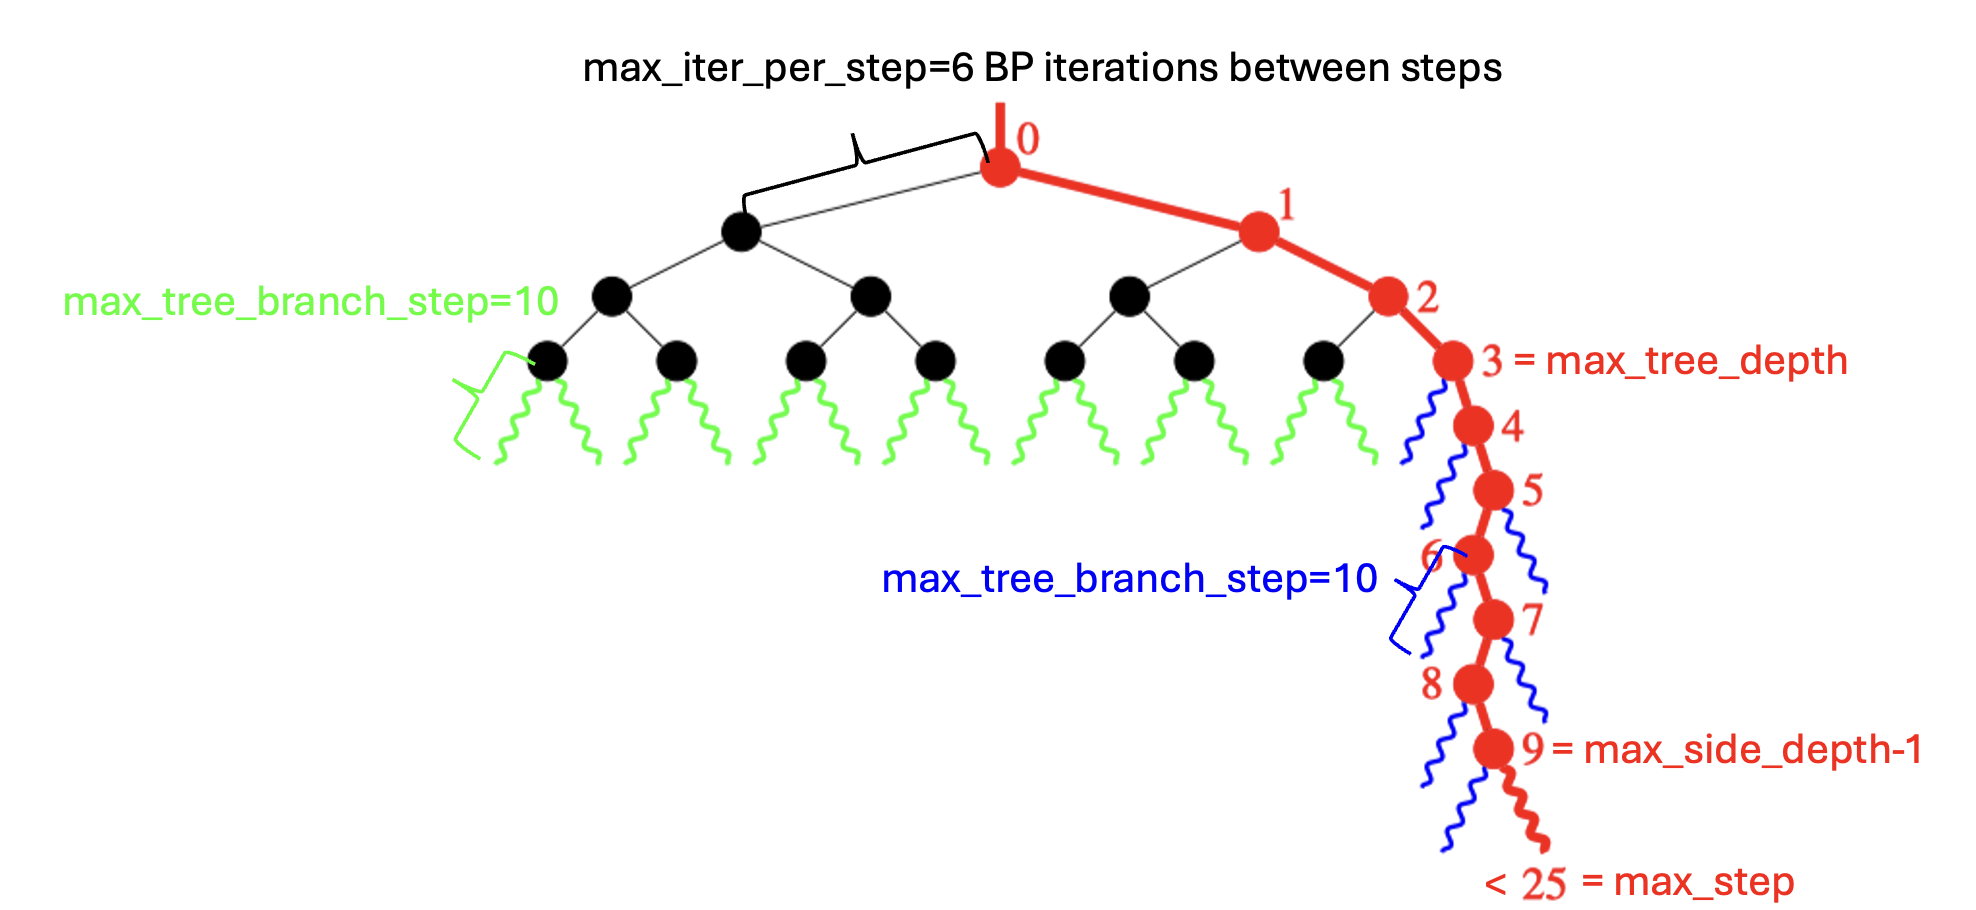

In [23]:
# sample error strings and syndromes
num_shots = 10000
err = np.random.binomial(1, p, (num_shots, code.N)) # [num_shots, N]
syndrome = (err @ code.hx.T) % 2 # [num_shots, N_half]
num_flag_err = 0
gdg_num_err = 0
for i in range(num_shots):
    e_hat_gdg = bpgdg.decode(syndrome[i])  # input syndrome
    num_flag_err += 1 - bpgdg.converge     # get whether GDG converged (syndrome consistent with input)
    e_diff = (e_hat_gdg + err[i]) % 2
    logical_err = ((e_diff @ code.hz_perp.T) % 2).any() # test logical errors, this captures convergence test
    gdg_num_err += logical_err
    
print("GDG: num flagged error", num_flag_err)
print(f"GDG: num logical error {gdg_num_err}/{num_shots}, LER {gdg_num_err/num_shots}")

GDG: num flagged error 0
GDG: num logical error 1448/10000, LER 0.1448


# Comparison to BP+OSD on data qubit noise

In [7]:
def data_qubit_noise_decoding(code, p, num_shots=1000, osd_orders=[10], osd_factor=0.625, skip_gdg=False,
                              max_step=40, max_tree_step=30, max_iter_per_step=6):                                                     
    print(f"hx shape {code.hx.shape}, hz_perp shape {code.hz_perp.shape}")
#     print(f"girth hx {find_girth(code.hx)}, hz {find_girth(code.hz)}") # a bit slow for the 882 code
    err = np.random.binomial(1, p, (num_shots, code.N)) # [num_shots, N]
    syndrome = (err @ code.hx.T) % 2 # [num_shots, N_half]
    priors = np.ones(code.N) * p
                                                         
    start_time = time.perf_counter()

    for order in osd_orders:
        osd_num_err = 0
        osd0_num_err = 0
        bpd = bposd_decoder(
            code.hx, # the parity check matrix
            error_rate=p, # does not matter as channel_prob is set
            channel_probs=priors, # override "error_rate" input variable
            max_iter=100,
            bp_method="minimum_sum_log", # messages are not clipped, may have numerical issues
            ms_scaling_factor=osd_factor, # usually {0.5, 0.625, 0.8, 1.0} suffice
            osd_method="osd_cs", # the OSD method. Choose from:  "osd_e", "osd_cs", "osd0"
            osd_order=order, # use -1 for BP alone
            input_vector_type="syndrome",
        )
        for i in range(num_shots):
            s = syndrome[i]
            e_hat_osd = bpd.decode(s) # can extract osd_0 result via bpd.osd0_decoding when using higher order osd
            e_diff = (e_hat_osd + err[i]) % 2
            logical_err = ((e_diff @ code.hz_perp.T) % 2).any()
            osd_num_err += logical_err
            e_diff = (bpd.osd0_decoding + err[i]) % 2
            logical_err = ((e_diff @ code.hz_perp.T) % 2).any()
            osd0_num_err += logical_err
            
        print(f"OSD order 0: num logical error {osd0_num_err}/{num_shots}, LER {osd0_num_err/num_shots}")
        print(f"OSD order {order}: num logical error {osd_num_err}/{num_shots}, LER {osd_num_err/num_shots}")
    
    end_time = time.perf_counter()
    print("Elapsed time:", end_time-start_time)  
    if skip_gdg: return
    
    
    gdg_num_err = 0
    num_flag_err = 0
    start_time = time.perf_counter()   
    bpgdg = bpgdg_decoder(
        code.hx, # shape (num_row, num_col) = (N/2, N)
        channel_probs=priors,
        max_iter_per_step=max_iter_per_step,
        gdg_factor=0.625,
        max_step=max_step, # have to use larger max_step for longer block-length codes
        max_tree_depth=4,
        max_side_depth=20,
        max_tree_branch_step=max_tree_step,
        max_side_branch_step=max_step-20,
        multi_thread=True,
        low_error_mode=True, # always use low error mode
        # not much error rate difference to setting max_iter=0 (no preprocessing, do not re-order columns)
        # but greatly improve amortized time, because most samples already converge in the preprocessing
        max_iter=24,
        ms_scaling_factor=0.625,
        new_n=code.N # setting to `None` has the same effect because num_row = num_col/2
    )

    for i in range(num_shots):
        s = syndrome[i]
        e_hat_gdg = bpgdg.decode(s)  
        num_flag_err += 1 - bpgdg.converge
        e_diff = (e_hat_gdg + err[i]) % 2
        logical_err = ((e_diff @ code.hz_perp.T) % 2).any()
        gdg_num_err += logical_err


    print("GDG: num flagged error", num_flag_err)
    print(f"GDG: num logical error {gdg_num_err}/{num_shots}, LER {gdg_num_err/num_shots}")
    end_time = time.perf_counter()
    print("Elapsed time:", end_time-start_time)  

In [3]:
code, A_list, B_list = create_bivariate_bicycle_codes(6, 6, [3], [1,2], [1,2], [3])     # [[72,12,6]]
code, A_list, B_list = create_bivariate_bicycle_codes(15, 3, [9], [1,2], [2,7], [0])    # [[90,8,10]]
code, A_list, B_list = create_bivariate_bicycle_codes(9, 6, [3], [1,2], [1,2], [3])     # [[108,8,10]]
code, A_list, B_list = create_bivariate_bicycle_codes(12, 6, [3], [1,2], [1,2], [3])    # [[144,12,12]]
code, A_list, B_list = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3])   # [[288,12,18]]
code, A_list, B_list = create_bivariate_bicycle_codes(30, 6, [9], [1,2], [25,26], [3])  # [[360,12,<=24]]
code, A_list, B_list = create_bivariate_bicycle_codes(21,18, [3], [10,17], [3,19], [5]) # [[756,16,<=34]]

In [3]:
code, _, _ = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3])   # [[288,12,18]]
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, 
                          osd_orders=[10], osd_factor=0.625, # use osd_factor=0.5 for N<=144, and 0.625 for N>=288
                          # use default GDG parameters for 288, increase max_step and max_tree_branch_step when N larger
                         )
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, osd_orders=[10], osd_factor=0.625)
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, osd_orders=[10], osd_factor=0.625)

hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 121/10000000, LER 1.21e-05
OSD order 10: num logical error 6/10000000, LER 6e-07
Elapsed time: 560.2224329505116
GDG: num flagged error 0
GDG: num logical error 1/10000000, LER 1e-07
Elapsed time: 766.1276751365513
hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 120/10000000, LER 1.2e-05
OSD order 10: num logical error 5/10000000, LER 5e-07
Elapsed time: 596.1525556407869
GDG: num flagged error 0
GDG: num logical error 1/10000000, LER 1e-07
Elapsed time: 765.9887262638658
hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 121/10000000, LER 1.21e-05
OSD order 10: num logical error 13/10000000, LER 1.3e-06
Elapsed time: 596.8310022968799
GDG: num flagged error 1
GDG: num logical error 2/10000000, LER 2e-07
Elapsed time: 762.9431126601994


In [4]:
code, _, _ = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3])   # [[288,12,18]]
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, 
                          osd_orders=[10], osd_factor=0.625, # use osd_factor=0.5 for N<=144, and 0.625 for N>=288
                          # use default GDG parameters for 288, increase max_step and max_tree_branch_step when N larger
                         )
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, osd_orders=[10], osd_factor=0.625)
data_qubit_noise_decoding(code, p=0.02, num_shots=10000000, osd_orders=[10], osd_factor=0.625)

hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 106/10000000, LER 1.06e-05
OSD order 10: num logical error 4/10000000, LER 4e-07
Elapsed time: 600.3871821202338
GDG: num flagged error 0
GDG: num logical error 1/10000000, LER 1e-07
Elapsed time: 764.4211675077677
hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 109/10000000, LER 1.09e-05
OSD order 10: num logical error 3/10000000, LER 3e-07
Elapsed time: 599.8870299551636
GDG: num flagged error 0
GDG: num logical error 0/10000000, LER 0.0
Elapsed time: 764.4919641241431
hx shape (144, 288), hz_perp shape (150, 288)
OSD order 0: num logical error 102/10000000, LER 1.02e-05
OSD order 10: num logical error 5/10000000, LER 5e-07
Elapsed time: 599.2125952467322
GDG: num flagged error 1
GDG: num logical error 1/10000000, LER 1e-07
Elapsed time: 764.0700909607112
